<img src="https://github.com/hernancontigiani/ceia_memorias_especializacion/raw/master/Figures/logoFIUBA.jpg" width="500" align="center">


# Procesamiento de lenguaje natural
## Modelo de lenguaje con tokenización por caracteres

### Datos del alumno:

- Alumno: Víctor David Silva
- Cohorte: 14
- Corpus: Magic History - Family Values

### Consigna
- Seleccionar un corpus de texto sobre el cual entrenar el modelo de lenguaje.
- Realizar el pre-procesamiento adecuado para tokenizar el corpus, estructurar el dataset y separar entre datos de entrenamiento y validación.
- Proponer arquitecturas de redes neuronales basadas en unidades recurrentes para implementar un modelo de lenguaje.
- Con el o los modelos que consideren adecuados, generar nuevas secuencias a partir de secuencias de contexto con las estrategias de greedy search y beam search determístico y estocástico. En este último caso observar el efecto de la temperatura en la generación de secuencias.


### Sugerencias
- Durante el entrenamiento, guiarse por el descenso de la perplejidad en los datos de validación para finalizar el entrenamiento. Para ello se provee un callback.
- Explorar utilizar SimpleRNN (celda de Elman), LSTM y GRU.
- rmsprop es el optimizador recomendado para la buena convergencia. No obstante se pueden explorar otros.


In [2]:
import random
import io
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from tensorflow import keras
from tensorflow.keras import layers
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, Dropout
from tensorflow.keras.losses import SparseCategoricalCrossentropy

In [3]:
import tensorflow as tf

# Check for TensorFlow GPU access
print(f"TensorFlow has access to the following devices:\n{tf.config.list_physical_devices()}")

# See TensorFlow version
print(f"TensorFlow version: {tf.__version__}")

TensorFlow has access to the following devices:
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
TensorFlow version: 2.13.0


### Datos
Utilizaremos como dataset canciones de bandas de habla inglés.

In [4]:
# descargar de textos.info
import urllib.request

# Para leer y parsear el texto en HTML de wikipedia
import bs4 as bs

In [5]:
raw_html = urllib.request.urlopen('https://magic.wizards.com/en/news/magic-story/family-values-2015-11-11')#'https://www.textos.info/sun-tzu/el-arte-de-la-guerra/ebook')
raw_html = raw_html.read()

# Parsear artículo, 'lxml' es el parser a utilizar
article_html = bs.BeautifulSoup(raw_html, 'lxml')

# Encontrar todos los párrafos del HTML (bajo el tag <p>)
# y tenerlos disponible como lista
article_paragraphs = article_html.find_all('p')

article_text = ''

for para in article_paragraphs:
    article_text += para.text + ' '

# pasar todo el texto a minúscula
article_text = article_text.lower()

In [6]:
from bs4 import BeautifulSoup

# Crear una cadena de ejemplo de HTML
html_doc = "<html><head><title>The Dormouse's story</title></head><body><p class='title'><b>The Dormouse's story</b></p></body></html>"

# Parsear la cadena HTML con lxml
soup = BeautifulSoup(html_doc, 'lxml')
print(soup.prettify())


<html>
 <head>
  <title>
   The Dormouse's story
  </title>
 </head>
 <body>
  <p class="title">
   <b>
    The Dormouse's story
   </b>
  </p>
 </body>
</html>



In [7]:
# en article text se encuentra el texto de todo el libro
article_text[:1000]

"teysa karlov is a formidable force in the courts of the city-plane of ravnica, but she wants more. with her extraordinary command of ravnica's law-magic and the help of a boros soldier, she is finally ready to make a bid for power. but she still has to contend with her treacherous, domineering ancestor karlov, who hasn't let being dead slow him down\xa0.\xa0.\xa0.  teysa karlov had spent another full day being yelled at by the dead. this time, the orzhov ghost council had failed to see why condemning a debtor to five hundred years of servitude was problematic in the eyes of the law. teysa had argued till her throat stung. the grand envoy of the orzhov collapsed into her favorite chair, cane leaning at hand. one of the grugg brothers had tidied her desk (bless him) and had left a pile of papers to go through. teysa karlov carefully sorted and scanned her old mail before she tossed it into the crackling fireplace of her study. an update on tunneling progress from tajic. a demand of comp

### Elegir el tamaño del contexto

En este caso, como el modelo de lenguaje es por caracteres, todo un gran corpus
de texto puede ser considerado un documento en sí mismo y el tamaño de contexto
puede ser elegido con más libertad en comparación a un modelo de lenguaje tokenizado por palabras y dividido en documentos más acotados.

In [8]:
# seleccionamos el tamaño de contexto
max_context_size = 100

In [127]:
# Usaremos las utilidades de procesamiento de textos y secuencias de Keras
from tensorflow.keras.utils import pad_sequences # se utilizará para padding

In [10]:
# en este caso el vocabulario es el conjunto único de caracteres que existe en todo el texto
# no va a ser de miles de componentes
chars_vocab = set(article_text)

In [11]:
# la longitud de vocabulario de caracteres es:
len(chars_vocab)

44

In [58]:
# Construimos los dicionarios que asignan índices a caracteres y viceversa.
# El diccionario `char2idx` servirá como tokenizador.
char2idx = {k: v for v,k in enumerate(chars_vocab)}
idx2char = {v: k for k,v in char2idx.items()}

###  Tokenizar

In [13]:
# tokenizamos el texto completo
tokenized_text = [char2idx[ch] for ch in article_text]

In [14]:
tokenized_text[:1000]

[20,
 37,
 18,
 16,
 13,
 4,
 10,
 13,
 35,
 0,
 24,
 32,
 4,
 36,
 16,
 4,
 13,
 4,
 12,
 24,
 35,
 23,
 36,
 17,
 13,
 25,
 0,
 37,
 4,
 12,
 24,
 35,
 1,
 37,
 4,
 36,
 22,
 4,
 20,
 30,
 37,
 4,
 1,
 24,
 7,
 35,
 20,
 16,
 4,
 24,
 12,
 4,
 20,
 30,
 37,
 4,
 1,
 36,
 20,
 18,
 31,
 5,
 0,
 13,
 22,
 37,
 4,
 24,
 12,
 4,
 35,
 13,
 32,
 22,
 36,
 1,
 13,
 43,
 4,
 25,
 7,
 20,
 4,
 16,
 30,
 37,
 4,
 29,
 13,
 22,
 20,
 16,
 4,
 23,
 24,
 35,
 37,
 42,
 4,
 29,
 36,
 20,
 30,
 4,
 30,
 37,
 35,
 4,
 37,
 15,
 20,
 35,
 13,
 24,
 35,
 17,
 36,
 22,
 13,
 35,
 18,
 4,
 1,
 24,
 23,
 23,
 13,
 22,
 17,
 4,
 24,
 12,
 4,
 35,
 13,
 32,
 22,
 36,
 1,
 13,
 34,
 16,
 4,
 0,
 13,
 29,
 31,
 23,
 13,
 14,
 36,
 1,
 4,
 13,
 22,
 17,
 4,
 20,
 30,
 37,
 4,
 30,
 37,
 0,
 5,
 4,
 24,
 12,
 4,
 13,
 4,
 25,
 24,
 35,
 24,
 16,
 4,
 16,
 24,
 0,
 17,
 36,
 37,
 35,
 43,
 4,
 16,
 30,
 37,
 4,
 36,
 16,
 4,
 12,
 36,
 22,
 13,
 0,
 0,
 18,
 4,
 35,
 37,
 13,
 17,
 18,
 4,
 20,
 24,
 4,
 23,
 

### Organizando y estructurando el dataset

In [15]:
# separaremos el dataset entre entrenamiento y validación.
# `p_val` será la proporción del corpus que se reservará para validación
# `num_val` es la cantidad de secuencias de tamaño `max_context_size` que se usará en validación
p_val = 0.1
num_val = int(np.ceil(len(tokenized_text)*p_val/max_context_size))

In [16]:
# separamos la porción de texto utilizada en entrenamiento de la de validación.
train_text = tokenized_text[:-num_val*max_context_size]
val_text = tokenized_text[-num_val*max_context_size:]

In [17]:
tokenized_sentences_val = [val_text[init*max_context_size:init*(max_context_size+1)] for init in range(num_val)]

In [18]:
tokenized_sentences_train = [train_text[init:init+max_context_size] for init in range(len(train_text)-max_context_size+1)]

In [19]:
X = np.array(tokenized_sentences_train[:-1])
y = np.array(tokenized_sentences_train[1:])

Nótese que estamos estructurando el problema de aprendizaje como *many-to-many*:

Entrada: secuencia de tokens [$x_0$, $x_1$, ..., $x_N$]

Target: secuencia de tokens [$x_1$, $x_2$, ..., $x_{N+1}$]

De manera que la red tiene que aprender que su salida deben ser los tokens desplazados en una posición y un nuevo token predicho (el N+1).

La ventaja de estructurar el aprendizaje de esta manera es que para cada token de target se propaga una señal de gradiente por el grafo de cómputo recurrente, que es mejor que estructurar el problema como *many-to-one* en donde sólo una señal de gradiente se propaga.

En este punto tenemos en la variable `tokenized_sentences` los versos tokenizados. Vamos a quedarnos con un conjunto de validación que utilizaremos para medir la calidad de la generación de secuencias con la métrica de Perplejidad.

In [20]:
X.shape

(22282, 100)

In [21]:
X[0,:10]

array([20, 37, 18, 16, 13,  4, 10, 13, 35,  0])

In [22]:
y[0,:10]

array([37, 18, 16, 13,  4, 10, 13, 35,  0, 24])

In [23]:
vocab_size = len(chars_vocab)

# Definiendo el modelo

In [24]:
from keras.layers import Input, TimeDistributed, CategoryEncoding, SimpleRNN, Dense
from keras.models import Model, Sequential

El modelo que se propone como ejemplo consume los índices de los tokens y los transforma en vectores OHE (en este caso no entrenamos una capa de embedding para caracteres). Esa transformación se logra combinando las capas `CategoryEncoding` que transforma a índices a vectores OHE y `TimeDistributed` que aplica la capa a lo largo de la dimensión "temporal" de la secuencia.

In [25]:
model = Sequential()

# Una capa es recibir un indice y me permite sacara a la salida un vector OHE y TimeDistrinuted, es una capa que modifica 
#otras capas. A toda la capa la a aplicar a cada elemento de la secuencia, no era necesario hacerlo con la de embedding, 
#porque ya la tenía.
# La idea es retocarlo.
model.add(TimeDistributed(CategoryEncoding(num_tokens=vocab_size, output_mode = "one_hot"),input_shape=(None,1)))
model.add(SimpleRNN(200, return_sequences=True, dropout=0.1, recurrent_dropout=0.1 ))
model.add(Dense(vocab_size, activation='softmax'))
model.compile(loss='sparse_categorical_crossentropy', optimizer='rmsprop')

model.summary()

2024-08-10 11:03:59.969511: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2024-08-10 11:03:59.969539: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-08-10 11:03:59.969545: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-08-10 11:03:59.970212: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-08-10 11:03:59.970525: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDist  (None, None, 44)          0         
 ributed)                                                        
                                                                 
 simple_rnn (SimpleRNN)      (None, None, 200)         49000     
                                                                 
 dense (Dense)               (None, None, 44)          8844      
                                                                 
Total params: 57844 (225.95 KB)
Trainable params: 57844 (225.95 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________



### Definir el modelo

Dado que por el momento no hay implementaciones adecuadas de la perplejidad que puedan operar en tiempo de entrenamiento, armaremos un Callback *ad-hoc* que la calcule en cada epoch.

**Nota**: un Callback es una rutina gatillada por algún evento, son muy útiles para relevar datos en diferentes momentos del desarrollo del modelo. En este caso queremos hacer un cálculo cada vez que termina una epoch de entrenamiento.

In [128]:
class PplCallback(keras.callbacks.Callback):

    '''
    Este callback es una solución ad-hoc para calcular al final de cada epoch de
    entrenamiento la métrica de Perplejidad sobre un conjunto de datos de validación.
    La perplejidad es una métrica cuantitativa para evaluar la calidad de la generación de secuencias.
    Además implementa la finalización del entrenamiento (Early Stopping)
    si la perplejidad no mejora después de `patience` epochs.
    '''

    def __init__(self, val_data, history_ppl,patience=5):
      # El callback lo inicializamos con secuencias de validación sobre las cuales
      # mediremos la perplejidad
      self.val_data = val_data

      self.target = []
      self.padded = []

      count = 0
      self.info = []
      self.min_score = np.inf
      self.patience_counter = 0
      self.patience = patience

      # nos movemos en todas las secuencias de los datos de validación
      for seq in self.val_data:

        len_seq = len(seq)
        # armamos todas las subsecuencias
        subseq = [seq[:i] for i in range(1,len_seq)]
        self.target.extend([seq[i] for i in range(1,len_seq)])

        if len(subseq)!=0:

          self.padded.append(pad_sequences(subseq, maxlen=max_context_size, padding='pre'))

          self.info.append((count,count+len_seq))
          count += len_seq

      self.padded = np.vstack(self.padded)


    def on_epoch_end(self, epoch, logs=None):

        # en `scores` iremos guardando la perplejidad de cada secuencia
        scores = []

        predictions = self.model.predict(self.padded,verbose=0)

        # para cada secuencia de validación
        for start,end in self.info:

          # en `probs` iremos guardando las probabilidades de los términos target
          probs = [predictions[idx_seq,-1,idx_vocab] for idx_seq, idx_vocab in zip(range(start,end),self.target[start:end])]

          # calculamos la perplejidad por medio de logaritmos
          scores.append(np.exp(-np.sum(np.log(probs))/(end-start)))

        # promediamos todos los scores e imprimimos el valor promedio
        current_score = np.mean(scores)
        history_ppl.append(current_score)
        print(f'\n mean perplexity: {current_score} \n')

        # chequeamos si tenemos que detener el entrenamiento
        if current_score < self.min_score:
          self.min_score = current_score
          self.model.save("my_model")
          print("Saved new model!")
          self.patience_counter = 0
        else:
          self.patience_counter += 1
          if self.patience_counter == self.patience:
            print("Stopping training...")
            self.model.stop_training = True


### Entrenamiento

In [68]:
# fiteamos, nótese el agregado del callback con su inicialización. El batch_size lo podemos seleccionar a mano
# en general, lo mejor es escoger el batch más grande posible que minimice el tiempo de cada época.
# En la variable `history_ppl` se guardarán los valores de perplejidad para cada época.
history_ppl = []
hist = model.fit(X, y, epochs=20, callbacks=[PplCallback(tokenized_sentences_val,history_ppl)], batch_size=256)

Epoch 1/20


2024-08-09 23:14:29.345281: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


88/88 [==============================] - ETA: 0s - loss: 2.8116

2024-08-09 23:24:47.196430: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



 mean perplexity: 13.82920057009448 

INFO:tensorflow:Assets written to: my_model/assets


INFO:tensorflow:Assets written to: my_model/assets


Saved new model!
88/88 [==============================] - 624s 7s/step - loss: 2.8116
Epoch 2/20
88/88 [==============================] - ETA: 0s - loss: 2.3607
 mean perplexity: 11.411099600049317 

INFO:tensorflow:Assets written to: my_model/assets


INFO:tensorflow:Assets written to: my_model/assets


Saved new model!
88/88 [==============================] - 612s 7s/step - loss: 2.3607
Epoch 3/20
88/88 [==============================] - ETA: 0s - loss: 2.1918
 mean perplexity: 10.17603413539455 

INFO:tensorflow:Assets written to: my_model/assets


INFO:tensorflow:Assets written to: my_model/assets


Saved new model!
88/88 [==============================] - 608s 7s/step - loss: 2.1918
Epoch 4/20
88/88 [==============================] - ETA: 0s - loss: 2.1091
 mean perplexity: 9.894725001455866 

INFO:tensorflow:Assets written to: my_model/assets


INFO:tensorflow:Assets written to: my_model/assets


Saved new model!
88/88 [==============================] - 609s 7s/step - loss: 2.1091
Epoch 5/20
88/88 [==============================] - ETA: 0s - loss: 2.0509
 mean perplexity: 9.84101538877813 

INFO:tensorflow:Assets written to: my_model/assets


INFO:tensorflow:Assets written to: my_model/assets


Saved new model!
88/88 [==============================] - 609s 7s/step - loss: 2.0509
Epoch 6/20
88/88 [==============================] - ETA: 0s - loss: 1.9989
 mean perplexity: 9.901482332313993 

88/88 [==============================] - 611s 7s/step - loss: 1.9989
Epoch 7/20
88/88 [==============================] - ETA: 0s - loss: 1.9504
 mean perplexity: 9.661904772168183 

INFO:tensorflow:Assets written to: my_model/assets


INFO:tensorflow:Assets written to: my_model/assets


Saved new model!
88/88 [==============================] - 618s 7s/step - loss: 1.9504
Epoch 8/20
88/88 [==============================] - ETA: 0s - loss: 1.9045
 mean perplexity: 10.167101571766091 

88/88 [==============================] - 483s 5s/step - loss: 1.9045
Epoch 9/20
88/88 [==============================] - ETA: 0s - loss: 1.8599
 mean perplexity: 9.702637256496917 

88/88 [==============================] - 354s 4s/step - loss: 1.8599
Epoch 10/20
88/88 [==============================] - ETA: 0s - loss: 1.8197
 mean perplexity: 9.715741437059886 

88/88 [==============================] - 380s 4s/step - loss: 1.8197
Epoch 11/20
88/88 [==============================] - ETA: 0s - loss: 1.7805
 mean perplexity: 9.555704677651365 

INFO:tensorflow:Assets written to: my_model/assets


INFO:tensorflow:Assets written to: my_model/assets


Saved new model!
88/88 [==============================] - 384s 4s/step - loss: 1.7805
Epoch 12/20
88/88 [==============================] - ETA: 0s - loss: 1.7435
 mean perplexity: 10.260329013962698 

88/88 [==============================] - 389s 4s/step - loss: 1.7435
Epoch 13/20
88/88 [==============================] - ETA: 0s - loss: 1.7110
 mean perplexity: 9.52727168714713 

INFO:tensorflow:Assets written to: my_model/assets


INFO:tensorflow:Assets written to: my_model/assets


Saved new model!
88/88 [==============================] - 390s 4s/step - loss: 1.7110
Epoch 14/20
88/88 [==============================] - ETA: 0s - loss: 1.6795
 mean perplexity: 9.696922623424024 

88/88 [==============================] - 384s 4s/step - loss: 1.6795
Epoch 15/20
88/88 [==============================] - ETA: 0s - loss: 1.6521
 mean perplexity: 9.830993206815746 

88/88 [==============================] - 389s 4s/step - loss: 1.6521
Epoch 16/20
88/88 [==============================] - ETA: 0s - loss: 1.6249
 mean perplexity: 10.747839396656795 

88/88 [==============================] - 388s 4s/step - loss: 1.6249
Epoch 17/20
88/88 [==============================] - ETA: 0s - loss: 1.6001
 mean perplexity: 10.79646121904266 

88/88 [==============================] - 390s 4s/step - loss: 1.6001
Epoch 18/20
88/88 [==============================] - ETA: 0s - loss: 1.5777
 mean perplexity: 10.021974626981324 

Stopping training...
88/88 [==============================] - 385s

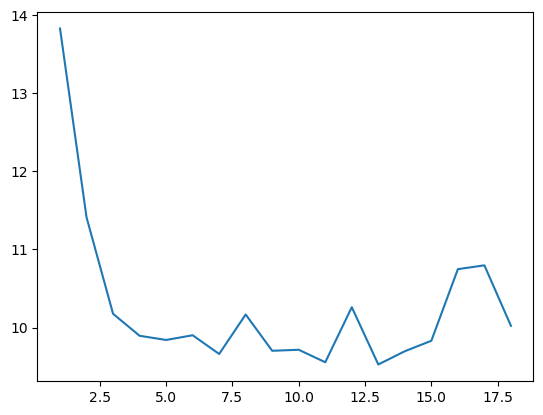

In [69]:
import matplotlib.pyplot as plt
import seaborn as sns

# Entrenamiento
epoch_count = range(1, len(history_ppl) + 1)
sns.lineplot(x=epoch_count,  y=history_ppl)
plt.show()

In [70]:
# Cargamos el mejor modelo guardado del entrenamiento para hacer inferencia
model = keras.models.load_model('my_model')


### Predicción del próximo caracter

In [29]:
# Se puede usar gradio para probar el modelo
# Gradio es una herramienta muy útil para crear interfaces para ensayar modelos
# https://gradio.app/

!pip install -q gradio

In [30]:
import gradio as gr

def model_response(human_text):

    # Encodeamos
    encoded = [char2idx[ch] for ch in human_text.lower() ]
    # Si tienen distinto largo
    encoded = pad_sequences([encoded], maxlen=max_context_size, padding='pre')

    # Predicción softmax
    y_hat = np.argmax(model.predict(encoded)[0,-1,:])


    # Debemos buscar en el vocabulario el caracter
    # que corresopnde al indice (y_hat) predicho por le modelo
    out_word = ''
    out_word = idx2char[y_hat]

    # Agrego la palabra a la frase predicha
    return human_text + out_word

iface = gr.Interface(
    fn=model_response,
    inputs=["textbox"],
    outputs="text")

iface.launch(debug=True)

Running on local URL:  http://127.0.0.1:7860

To create a public link, set `share=True` in `launch()`.


2024-08-09 22:45:18.784599: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 1s 518ms/step
Keyboard interruption in main thread... closing server.


### Generación de secuencias

In [71]:
def generate_seq(model, seed_text, max_length, n_words):
    """
        Exec model sequence prediction

        Args:
            model (keras): modelo entrenado
            seed_text (string): texto de entrada (input_seq)
            max_length (int): máxima longitud de la sequencia de entrada
            n_words (int): números de caracteres a agregar a la sequencia de entrada
        returns:
            output_text (string): sentencia con las "n_words" agregadas
    """
    output_text = seed_text
	# generate a fixed number of words
    for _ in range(n_words):
		# Encodeamos
        encoded = [char2idx[ch] for ch in output_text.lower() ]
		# Si tienen distinto largo
        encoded = pad_sequences([encoded], maxlen=max_length, padding='pre')

		# Predicción softmax
        y_hat = np.argmax(model.predict(encoded,verbose=0)[0,-1,:])
		# Vamos concatenando las predicciones
        out_word = ''

        out_word = idx2char[y_hat]

		# Agrego las palabras a la frase predicha
        output_text += out_word
    return output_text

In [72]:
input_text='Teysa Karlov had spent another full day '

generate_seq(model, input_text, max_length=max_context_size, n_words=30)

2024-08-10 02:01:24.634501: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


'Teysa Karlov had spent another full day chand the knight of the obzeda'

###  Beam search y muestreo aleatorio

In [73]:
# funcionalidades para hacer encoding y decoding

def encode(text,max_length=max_context_size):

    encoded = [char2idx[ch] for ch in text]
    encoded = pad_sequences([encoded], maxlen=max_length, padding='pre')

    return encoded

def decode(seq):
    return ''.join([idx2char[ch] for ch in seq])

In [74]:
from scipy.special import softmax

# función que selecciona candidatos para el beam search
def select_candidates(pred,num_beams,vocab_size,history_probs,history_tokens,temp,mode):

  # colectar todas las probabilidades para la siguiente búsqueda
  pred_large = []

  for idx,pp in enumerate(pred):
    pred_large.extend(np.log(pp+1E-10)+history_probs[idx])

  pred_large = np.array(pred_large)

  # criterio de selección
  if mode == 'det':
    idx_select = np.argsort(pred_large)[::-1][:num_beams] # beam search determinista
  elif mode == 'sto':
    idx_select = np.random.choice(np.arange(pred_large.shape[0]), num_beams, p=softmax(pred_large/temp)) # beam search con muestreo aleatorio
  else:
    raise ValueError(f'Wrong selection mode. {mode} was given. det and sto are supported.')

  # traducir a índices de token en el vocabulario
  new_history_tokens = np.concatenate((np.array(history_tokens)[idx_select//vocab_size],
                        np.array([idx_select%vocab_size]).T),
                      axis=1)

  # devolver el producto de las probabilidades (log) y la secuencia de tokens seleccionados
  return pred_large[idx_select.astype(int)], new_history_tokens.astype(int)


def beam_search(model,num_beams,num_words,input,temp=1,mode='det'):

    # first iteration

    # encode
    encoded = encode(input)

    # first prediction
    y_hat = model.predict(encoded,verbose=0)[0,-1,:]

    # get vocabulary size
    vocab_size = y_hat.shape[0]

    # initialize history
    history_probs = [0]*num_beams
    history_tokens = [encoded[0]]*num_beams

    # select num_beams candidates
    history_probs, history_tokens = select_candidates([y_hat],
                                        num_beams,
                                        vocab_size,
                                        history_probs,
                                        history_tokens,
                                        temp,
                                        mode)

    # beam search loop
    for i in range(num_words-1):

      preds = []

      for hist in history_tokens:

        # actualizar secuencia de tokens
        input_update = np.array([hist[i+1:]]).copy()

        # predicción
        y_hat = model.predict(input_update,verbose=0)[0,-1,:]

        preds.append(y_hat)

      history_probs, history_tokens = select_candidates(preds,
                                                        num_beams,
                                                        vocab_size,
                                                        history_probs,
                                                        history_tokens,
                                                        temp,
                                                        mode)

    return history_tokens

In [81]:
# predicción con beam search
salidas = beam_search(model,num_beams=10,num_words=20,input="teysa karlov had spent another full day")

In [82]:
salidas[0]

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  5, 39, 19, 29, 11, 27,  7,
       11, 28, 18,  9,  2, 27, 14, 11, 12, 27, 29, 15, 39, 25,  5, 27, 11,
       25,  9,  5, 14, 39, 28, 27,  4,  8, 18, 18, 27, 12, 11, 19, 27,  9,
        4, 27,  5, 14, 39, 27,  9, 10, 22, 39, 12, 11,  5, 16, 29, 27, 37,
       14])

In [83]:
# veamos las salidas
decode(salidas[0])

"iiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiteysa karlov had spent another full day of the obzedat's ch"

Modelo SimpleRNN:

Se observa que la curva de perplexity disminuye y al final vuelve a incrementarse un poco. 

La generación de secuencia muestra algo con sentido aprendido del corpus.

El beam search muestra muchas veces la i que sería el token 0, el cual en los otros modelos se corrige.

### Modelo 2 - LSTM con 2 capas

In [27]:
model = Sequential()

# Una capa es recibir un indice y me permite sacara a la salida un vector OHE y TimeDistrinuted, es una capa que modifica 
#otras capas. A toda la capa la a aplicar a cada elemento de la secuencia, no era necesario hacerlo con la de embedding, 
#porque ya la tenía.
# La idea es retocarlo.
model.add(TimeDistributed(CategoryEncoding(num_tokens=vocab_size, output_mode = "one_hot"),input_shape=(None,1)))
model.add(LSTM(100, return_sequences=True, dropout=0.1, recurrent_dropout=0.1 ))
model.add(LSTM(100, return_sequences=True, dropout=0.1, recurrent_dropout=0.1 ))
model.add(Dense(vocab_size, activation='softmax'))
model.compile(loss='sparse_categorical_crossentropy', optimizer='rmsprop')

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_1 (TimeDi  (None, None, 44)          0         
 stributed)                                                      
                                                                 
 lstm (LSTM)                 (None, None, 100)         58000     
                                                                 
 lstm_1 (LSTM)               (None, None, 100)         80400     
                                                                 
 dense_1 (Dense)             (None, None, 44)          4444      
                                                                 
Total params: 142844 (557.98 KB)
Trainable params: 142844 (557.98 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [28]:
# fiteamos, nótese el agregado del callback con su inicialización. El batch_size lo podemos seleccionar a mano
# en general, lo mejor es escoger el batch más grande posible que minimice el tiempo de cada época.
# En la variable `history_ppl` se guardarán los valores de perplejidad para cada época.
history_ppl = []
hist = model.fit(X, y, epochs=20, callbacks=[PplCallback(tokenized_sentences_val,history_ppl)], batch_size=256)

Epoch 1/20


2024-08-10 11:04:21.642885: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


88/88 [==============================] - ETA: 0s - loss: 3.0332 

2024-08-10 12:01:56.811926: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



 mean perplexity: 19.621762440311443 

INFO:tensorflow:Assets written to: my_model/assets


INFO:tensorflow:Assets written to: my_model/assets


Saved new model!
88/88 [==============================] - 3468s 39s/step - loss: 3.0332
Epoch 2/20
88/88 [==============================] - ETA: 0s - loss: 2.8687 
 mean perplexity: 15.956332534541358 

INFO:tensorflow:Assets written to: my_model/assets


INFO:tensorflow:Assets written to: my_model/assets


Saved new model!
88/88 [==============================] - 3618s 41s/step - loss: 2.8687
Epoch 3/20
88/88 [==============================] - ETA: 0s - loss: 2.6727  
 mean perplexity: 13.391273378564902 

INFO:tensorflow:Assets written to: my_model/assets


INFO:tensorflow:Assets written to: my_model/assets


Saved new model!
88/88 [==============================] - 6855s 78s/step - loss: 2.6727
Epoch 4/20
88/88 [==============================] - ETA: 0s - loss: 2.5448  
 mean perplexity: 12.562569834382257 

INFO:tensorflow:Assets written to: my_model/assets


INFO:tensorflow:Assets written to: my_model/assets


Saved new model!
88/88 [==============================] - 6223s 71s/step - loss: 2.5448
Epoch 5/20
88/88 [==============================] - ETA: 0s - loss: 2.4640 
 mean perplexity: 12.119648977470925 

INFO:tensorflow:Assets written to: my_model/assets


INFO:tensorflow:Assets written to: my_model/assets


Saved new model!
88/88 [==============================] - 3817s 43s/step - loss: 2.4640
Epoch 6/20
88/88 [==============================] - ETA: 0s - loss: 2.3966 
 mean perplexity: 11.588840131071851 

INFO:tensorflow:Assets written to: my_model/assets


INFO:tensorflow:Assets written to: my_model/assets


Saved new model!
88/88 [==============================] - 3358s 38s/step - loss: 2.3966
Epoch 7/20
88/88 [==============================] - ETA: 0s - loss: 2.3342  
 mean perplexity: 10.970237564871226 

INFO:tensorflow:Assets written to: my_model/assets


INFO:tensorflow:Assets written to: my_model/assets


Saved new model!
88/88 [==============================] - 5797s 66s/step - loss: 2.3342
Epoch 8/20
88/88 [==============================] - ETA: 0s - loss: 2.2749  
 mean perplexity: 10.759571155694028 

INFO:tensorflow:Assets written to: my_model/assets


INFO:tensorflow:Assets written to: my_model/assets


Saved new model!
88/88 [==============================] - 5376s 61s/step - loss: 2.2749
Epoch 9/20
88/88 [==============================] - ETA: 0s - loss: 2.2185 
 mean perplexity: 10.774378900916705 

88/88 [==============================] - 3392s 39s/step - loss: 2.2185
Epoch 10/20
88/88 [==============================] - ETA: 0s - loss: 2.1631 
 mean perplexity: 10.733635961337905 

INFO:tensorflow:Assets written to: my_model/assets


INFO:tensorflow:Assets written to: my_model/assets


Saved new model!
88/88 [==============================] - 3405s 39s/step - loss: 2.1631
Epoch 11/20
88/88 [==============================] - ETA: 0s - loss: 2.1114 
 mean perplexity: 10.519682562568658 

INFO:tensorflow:Assets written to: my_model/assets


INFO:tensorflow:Assets written to: my_model/assets


Saved new model!
88/88 [==============================] - 3403s 39s/step - loss: 2.1114
Epoch 12/20
88/88 [==============================] - ETA: 0s - loss: 2.0606 
 mean perplexity: 10.520031981071133 

88/88 [==============================] - 3394s 39s/step - loss: 2.0606
Epoch 13/20
88/88 [==============================] - ETA: 0s - loss: 2.0129 
 mean perplexity: 10.144785553940709 

INFO:tensorflow:Assets written to: my_model/assets


INFO:tensorflow:Assets written to: my_model/assets


Saved new model!
88/88 [==============================] - 3382s 38s/step - loss: 2.0129
Epoch 14/20
88/88 [==============================] - ETA: 0s - loss: 1.9665 
 mean perplexity: 10.026932041450475 

INFO:tensorflow:Assets written to: my_model/assets


INFO:tensorflow:Assets written to: my_model/assets


Saved new model!
88/88 [==============================] - 3363s 38s/step - loss: 1.9665
Epoch 15/20
88/88 [==============================] - ETA: 0s - loss: 1.9238 
 mean perplexity: 10.008115944389095 

INFO:tensorflow:Assets written to: my_model/assets


INFO:tensorflow:Assets written to: my_model/assets


Saved new model!
88/88 [==============================] - 3329s 38s/step - loss: 1.9238
Epoch 16/20
88/88 [==============================] - ETA: 0s - loss: 1.8818 
 mean perplexity: 10.427539278411734 

88/88 [==============================] - 3341s 38s/step - loss: 1.8818
Epoch 17/20
88/88 [==============================] - ETA: 0s - loss: 1.8416 
 mean perplexity: 9.637350745161982 

INFO:tensorflow:Assets written to: my_model/assets


INFO:tensorflow:Assets written to: my_model/assets


Saved new model!
88/88 [==============================] - 3327s 38s/step - loss: 1.8416
Epoch 18/20
88/88 [==============================] - ETA: 0s - loss: 1.8028 
 mean perplexity: 10.464309348007209 

88/88 [==============================] - 3297s 37s/step - loss: 1.8028
Epoch 19/20
88/88 [==============================] - ETA: 0s - loss: 1.7671 
 mean perplexity: 10.72188583768195 

88/88 [==============================] - 3295s 37s/step - loss: 1.7671
Epoch 20/20
88/88 [==============================] - ETA: 0s - loss: 1.7324 
 mean perplexity: 15.125817260381579 

88/88 [==============================] - 3287s 37s/step - loss: 1.7324


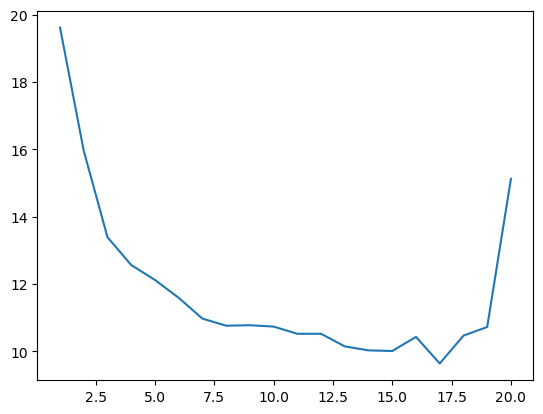

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns

# Entrenamiento
epoch_count = range(1, len(history_ppl) + 1)
sns.lineplot(x=epoch_count,  y=history_ppl)
plt.show()

In [30]:
# Cargamos el mejor modelo guardado del entrenamiento para hacer inferencia
model_2 = keras.models.load_model('my_model')

#### Generación de secuencias

In [38]:
def generate_seq(model, seed_text, max_length, n_words):
    """
        Exec model sequence prediction

        Args:
            model (keras): modelo entrenado
            seed_text (string): texto de entrada (input_seq)
            max_length (int): máxima longitud de la sequencia de entrada
            n_words (int): números de caracteres a agregar a la sequencia de entrada
        returns:
            output_text (string): sentencia con las "n_words" agregadas
    """
    output_text = seed_text
	# generate a fixed number of words
    for _ in range(n_words):
		# Encodeamos
        encoded = [char2idx[ch] for ch in output_text.lower() ]
		# Si tienen distinto largo
        encoded = pad_sequences([encoded], maxlen=max_length, padding='pre')

		# Predicción softmax
        y_hat = np.argmax(model.predict(encoded,verbose=0)[0,-1,:])
		# Vamos concatenando las predicciones
        out_word = ''

        out_word = idx2char[y_hat]

		# Agrego las palabras a la frase predicha
        output_text += out_word
    return output_text

In [39]:
input_text= 'Instead, the Grand Envoy of the Orzhov leaned forward,'#'Teysa Karlov had spent another full day '

generate_seq(model_2, input_text, max_length=max_context_size, n_words=30)

'Instead, the Grand Envoy of the Orzhov leaned forward, she stood of the obzedat of t'

#### Beam search

In [67]:
# funcionalidades para hacer encoding y decoding

def encode(text,max_length=max_context_size):

    encoded = [char2idx[ch] for ch in text]
    encoded = pad_sequences([encoded], maxlen=max_length, padding='pre')

    return encoded

def decode(seq):
    #return ''.join([idx2char[ch] for ch in seq])
    return ''.join([idx2char[ch] for ch in seq if ch != 0])

In [68]:
from scipy.special import softmax

# función que selecciona candidatos para el beam search
def select_candidates(pred,num_beams,vocab_size,history_probs,history_tokens,temp,mode):

  # colectar todas las probabilidades para la siguiente búsqueda
  pred_large = []

  for idx,pp in enumerate(pred):
    pred_large.extend(np.log(pp+1E-10)+history_probs[idx])

  pred_large = np.array(pred_large)

  # criterio de selección
  if mode == 'det':
    idx_select = np.argsort(pred_large)[::-1][:num_beams] # beam search determinista
  elif mode == 'sto':
    idx_select = np.random.choice(np.arange(pred_large.shape[0]), num_beams, p=softmax(pred_large/temp)) # beam search con muestreo aleatorio
  else:
    raise ValueError(f'Wrong selection mode. {mode} was given. det and sto are supported.')

  # traducir a índices de token en el vocabulario
  new_history_tokens = np.concatenate((np.array(history_tokens)[idx_select//vocab_size],
                        np.array([idx_select%vocab_size]).T),
                      axis=1)

  # devolver el producto de las probabilidades (log) y la secuencia de tokens seleccionados
  return pred_large[idx_select.astype(int)], new_history_tokens.astype(int)


def beam_search(model,num_beams,num_words,input,temp=1,mode='det'):

    # first iteration

    # encode
    encoded = encode(input)

    # first prediction
    y_hat = model.predict(encoded,verbose=0)[0,-1,:]

    # get vocabulary size
    vocab_size = y_hat.shape[0]

    # initialize history
    history_probs = [0]*num_beams
    history_tokens = [encoded[0]]*num_beams

    # select num_beams candidates
    history_probs, history_tokens = select_candidates([y_hat],
                                        num_beams,
                                        vocab_size,
                                        history_probs,
                                        history_tokens,
                                        temp,
                                        mode)

    # beam search loop
    for i in range(num_words-1):

      preds = []

      for hist in history_tokens:

        # actualizar secuencia de tokens
        input_update = np.array([hist[i+1:]]).copy()

        # predicción
        y_hat = model.predict(input_update,verbose=0)[0,-1,:]

        preds.append(y_hat)

      history_probs, history_tokens = select_candidates(preds,
                                                        num_beams,
                                                        vocab_size,
                                                        history_probs,
                                                        history_tokens,
                                                        temp,
                                                        mode)

    return history_tokens

In [83]:
# predicción con beam search
#salidas = beam_search(model_2,num_beams=10,num_words=20,input="teysa karlov")
salidas = beam_search(model_2,num_beams=5,num_words=25,input="teysa karlov is a formidable force in the courts of",temp=1.5,mode='sto')

In [84]:
# tenemos `num_beams` salidas ordenadas de mayor a menor likelihood
salidas.shape

(5, 125)

In [85]:
# veamos las salidas
for i in range(salidas.shape[0]):
    print(decode(salidas[i]))

teysa karov is a formidabe force in the courts of the with a becores of tp
teysa karov is a formidabe force in the courts of the with a becores of sh
teysa karov is a formidabe force in the courts of the with a becores of sn
teysa karov is a formidabe force in the courts of the with a becores of st
teysa karov is a formidabe force in the courts of the with a becores of th


Modelo LSTM (2 capas de 100 cada una):

Se observa que la curva de perplexity disminuye y al final vuelve a incrementarse un poco. 

La generación de secuencia muestra algo con sentido aprendido del corpus.

El beam search muestra diferentes opciones con sentido.

## Modelo 3: GRU

In [135]:
import tensorflow as tf

# Check for TensorFlow GPU access
print(f"TensorFlow has access to the following devices:\n{tf.config.list_physical_devices()}")

# See TensorFlow version
print(f"TensorFlow version: {tf.__version__}")

TensorFlow has access to the following devices:
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
TensorFlow version: 2.13.0


Se cambia el tamaño de contexto a 50. 

In [136]:
# seleccionamos el tamaño de contexto
max_context_size = 50

In [137]:
# en este caso el vocabulario es el conjunto único de caracteres que existe en todo el texto
# no va a ser de miles de componentes
chars_vocab = set(article_text)

# la longitud de vocabulario de caracteres es:
len(chars_vocab)

# Construimos los dicionarios que asignan índices a caracteres y viceversa.
# El diccionario `char2idx` servirá como tokenizador.
char2idx = {k: v for v,k in enumerate(chars_vocab)}
idx2char = {v: k for k,v in char2idx.items()}

In [138]:
# tokenizamos el texto completo
tokenized_text = [char2idx[ch] for ch in article_text]

# separaremos el dataset entre entrenamiento y validación.
# `p_val` será la proporción del corpus que se reservará para validación
# `num_val` es la cantidad de secuencias de tamaño `max_context_size` que se usará en validación
p_val = 0.1
num_val = int(np.ceil(len(tokenized_text)*p_val/max_context_size))

# separamos la porción de texto utilizada en entrenamiento de la de validación.
train_text = tokenized_text[:-num_val*max_context_size]
val_text = tokenized_text[-num_val*max_context_size:]

tokenized_sentences_val = [val_text[init*max_context_size:init*(max_context_size+1)] for init in range(num_val)]
tokenized_sentences_train = [train_text[init:init+max_context_size] for init in range(len(train_text)-max_context_size+1)]

X = np.array(tokenized_sentences_train[:-1])
y = np.array(tokenized_sentences_train[1:])

#Nótese que estamos estructurando el problema de aprendizaje como *many-to-many*:

#Entrada: secuencia de tokens [$x_0$, $x_1$, ..., $x_N$]
#Target: secuencia de tokens [$x_1$, $x_2$, ..., $x_{N+1}$]
# De manera que la red tiene que aprender que su salida deben ser los tokens desplazados en una posición y un nuevo token predicho (el N+1).
#La ventaja de estructurar el aprendizaje de esta manera es que para cada token de target se propaga una señal de gradiente por el grafo de cómputo recurrente, que es mejor que estructurar el problema como *many-to-one* en donde sólo una señal de gradiente se propaga.
#En este punto tenemos en la variable `tokenized_sentences` los versos tokenizados. Vamos a quedarnos con un conjunto de validación que utilizaremos para medir la calidad de la generación de secuencias con la métrica de Perplejidad.

print("X.shape ", X.shape)
print(X[0,:10])
print(y[0,:10])
vocab_size = len(chars_vocab)

X.shape  (22332, 50)
[20 37 18 16 13  4 10 13 35  0]
[37 18 16 13  4 10 13 35  0 24]


In [139]:
from keras.layers import GRU

#El modelo que se propone como ejemplo consume los índices de los tokens y los transforma en vectores OHE (en este caso no entrenamos una capa de embedding para caracteres). Esa transformación se logra combinando las capas `CategoryEncoding` que transforma a índices a vectores OHE y `TimeDistributed` que aplica la capa a lo largo de la dimensión "temporal" de la secuencia.
model = Sequential()

# Una capa es recibir un indice y me permite sacara a la salida un vector OHE y TimeDistrinuted, es una capa que modifica 
#otras capas. A toda la capa la a aplicar a cada elemento de la secuencia, no era necesario hacerlo con la de embedding, 
#porque ya la tenía.
# La idea es retocarlo.
model.add(TimeDistributed(CategoryEncoding(num_tokens=vocab_size, output_mode = "one_hot"),input_shape=(None,1)))
model.add(GRU(50, return_sequences=True, dropout=0.1, recurrent_dropout=0.1 ))
model.add(GRU(50, return_sequences=True, dropout=0.1, recurrent_dropout=0.1 ))
model.add(Dense(vocab_size, activation='softmax'))
model.compile(loss='sparse_categorical_crossentropy', optimizer='rmsprop')

model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_11 (TimeD  (None, None, 44)          0         
 istributed)                                                     
                                                                 
 gru_17 (GRU)                (None, None, 50)          14400     
                                                                 
 gru_18 (GRU)                (None, None, 50)          15300     
                                                                 
 dense_11 (Dense)            (None, None, 44)          2244      
                                                                 
Total params: 31944 (124.78 KB)
Trainable params: 31944 (124.78 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [140]:
# fiteamos, nótese el agregado del callback con su inicialización. El batch_size lo podemos seleccionar a mano
# en general, lo mejor es escoger el batch más grande posible que minimice el tiempo de cada época.
# En la variable `history_ppl` se guardarán los valores de perplejidad para cada época.
history_ppl = []
hist_3 = model.fit(X, y, epochs=20, callbacks=[PplCallback(tokenized_sentences_val,history_ppl)], batch_size=256)

Epoch 1/20


2024-08-12 01:40:39.185220: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


88/88 [==============================] - ETA: 0s - loss: 3.0427

2024-08-12 01:53:02.755563: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



 mean perplexity: 16.742140648771226 

INFO:tensorflow:Assets written to: my_model/assets


INFO:tensorflow:Assets written to: my_model/assets


Saved new model!
88/88 [==============================] - 763s 9s/step - loss: 3.0427
Epoch 2/20
88/88 [==============================] - ETA: 0s - loss: 2.6539
 mean perplexity: 12.281756018525279 

INFO:tensorflow:Assets written to: my_model/assets


INFO:tensorflow:Assets written to: my_model/assets


Saved new model!
88/88 [==============================] - 775s 9s/step - loss: 2.6539
Epoch 3/20
88/88 [==============================] - ETA: 0s - loss: 2.4516 
 mean perplexity: 10.973381815418959 

INFO:tensorflow:Assets written to: my_model/assets


INFO:tensorflow:Assets written to: my_model/assets


Saved new model!
88/88 [==============================] - 2426s 28s/step - loss: 2.4516
Epoch 4/20
88/88 [==============================] - ETA: 0s - loss: 2.3237 
 mean perplexity: 10.561241043639923 

INFO:tensorflow:Assets written to: my_model/assets


INFO:tensorflow:Assets written to: my_model/assets


Saved new model!
88/88 [==============================] - 2129s 24s/step - loss: 2.3237
Epoch 5/20
88/88 [==============================] - ETA: 0s - loss: 2.2199
 mean perplexity: 9.863225760009994 

INFO:tensorflow:Assets written to: my_model/assets


INFO:tensorflow:Assets written to: my_model/assets


Saved new model!
88/88 [==============================] - 779s 9s/step - loss: 2.2199
Epoch 6/20
88/88 [==============================] - ETA: 0s - loss: 2.1384 
 mean perplexity: 9.409001906248049 

INFO:tensorflow:Assets written to: my_model/assets


INFO:tensorflow:Assets written to: my_model/assets


Saved new model!
88/88 [==============================] - 1704s 19s/step - loss: 2.1384
Epoch 7/20
88/88 [==============================] - ETA: 0s - loss: 2.0714
 mean perplexity: 9.043356689822216 

INFO:tensorflow:Assets written to: my_model/assets


INFO:tensorflow:Assets written to: my_model/assets


Saved new model!
88/88 [==============================] - 751s 9s/step - loss: 2.0714
Epoch 8/20
88/88 [==============================] - ETA: 0s - loss: 2.0205
 mean perplexity: 8.838873840909512 

INFO:tensorflow:Assets written to: my_model/assets


INFO:tensorflow:Assets written to: my_model/assets


Saved new model!
88/88 [==============================] - 837s 10s/step - loss: 2.0205
Epoch 9/20
88/88 [==============================] - ETA: 0s - loss: 1.9752
 mean perplexity: 8.382199148991736 

INFO:tensorflow:Assets written to: my_model/assets


INFO:tensorflow:Assets written to: my_model/assets


Saved new model!
88/88 [==============================] - 844s 10s/step - loss: 1.9752
Epoch 10/20
88/88 [==============================] - ETA: 0s - loss: 1.9378
 mean perplexity: 8.179095907609854 

INFO:tensorflow:Assets written to: my_model/assets


INFO:tensorflow:Assets written to: my_model/assets


Saved new model!
88/88 [==============================] - 850s 10s/step - loss: 1.9378
Epoch 11/20
88/88 [==============================] - ETA: 0s - loss: 1.9064
 mean perplexity: 8.180481607515691 

88/88 [==============================] - 859s 10s/step - loss: 1.9064
Epoch 12/20
88/88 [==============================] - ETA: 0s - loss: 1.8783
 mean perplexity: 8.006481752568947 

INFO:tensorflow:Assets written to: my_model/assets


INFO:tensorflow:Assets written to: my_model/assets


Saved new model!
88/88 [==============================] - 855s 10s/step - loss: 1.8783
Epoch 13/20
88/88 [==============================] - ETA: 0s - loss: 1.8542
 mean perplexity: 7.800932671928521 

INFO:tensorflow:Assets written to: my_model/assets


INFO:tensorflow:Assets written to: my_model/assets


Saved new model!
88/88 [==============================] - 853s 10s/step - loss: 1.8542
Epoch 14/20
88/88 [==============================] - ETA: 0s - loss: 1.8340
 mean perplexity: 7.790020352582656 

INFO:tensorflow:Assets written to: my_model/assets


INFO:tensorflow:Assets written to: my_model/assets


Saved new model!
88/88 [==============================] - 843s 10s/step - loss: 1.8340
Epoch 15/20
88/88 [==============================] - ETA: 0s - loss: 1.8140
 mean perplexity: 8.053140156690262 

88/88 [==============================] - 846s 10s/step - loss: 1.8140
Epoch 16/20
88/88 [==============================] - ETA: 0s - loss: 1.7965
 mean perplexity: 7.7764298832772925 

INFO:tensorflow:Assets written to: my_model/assets


INFO:tensorflow:Assets written to: my_model/assets


Saved new model!
88/88 [==============================] - 843s 10s/step - loss: 1.7965
Epoch 17/20
88/88 [==============================] - ETA: 0s - loss: 1.7809
 mean perplexity: 7.571376363246052 

INFO:tensorflow:Assets written to: my_model/assets


INFO:tensorflow:Assets written to: my_model/assets


Saved new model!
88/88 [==============================] - 829s 9s/step - loss: 1.7809
Epoch 18/20
88/88 [==============================] - ETA: 0s - loss: 1.7682
 mean perplexity: 7.338908894154405 

INFO:tensorflow:Assets written to: my_model/assets


INFO:tensorflow:Assets written to: my_model/assets


Saved new model!
88/88 [==============================] - 829s 9s/step - loss: 1.7682
Epoch 19/20
88/88 [==============================] - ETA: 0s - loss: 1.7529
 mean perplexity: 7.490832237755292 

88/88 [==============================] - 841s 10s/step - loss: 1.7529
Epoch 20/20
88/88 [==============================] - ETA: 0s - loss: 1.7422
 mean perplexity: 7.493324680995947 

88/88 [==============================] - 704s 8s/step - loss: 1.7422


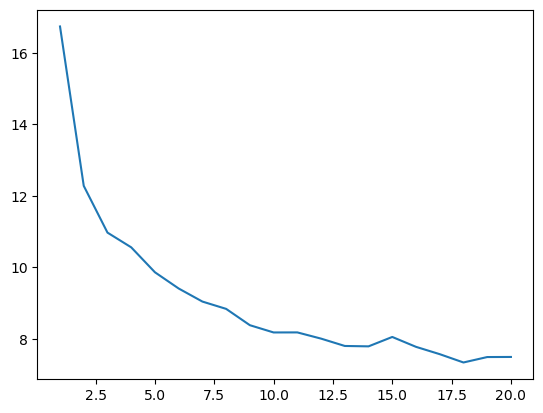

In [141]:
import matplotlib.pyplot as plt
import seaborn as sns

# Entrenamiento
epoch_count = range(1, len(history_ppl) + 1)
sns.lineplot(x=epoch_count,  y=history_ppl)
plt.show()

In [142]:
# Cargamos el mejor modelo guardado del entrenamiento para hacer inferencia
model_3 = keras.models.load_model('my_model')

#### Generación de secuencias

In [143]:
input_text= 'Instead, the Grand Envoy of the Orzhov leaned forward,'#'Teysa Karlov had spent another full day '

generate_seq(model_3, input_text, max_length=max_context_size, n_words=30)

2024-08-12 07:16:35.588198: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


'Instead, the Grand Envoy of the Orzhov leaned forward, she could and the living a co'

#### Beam search

In [144]:
# funcionalidades para hacer encoding y decoding

def encode(text,max_length=max_context_size):

    encoded = [char2idx[ch] for ch in text]
    encoded = pad_sequences([encoded], maxlen=max_length, padding='pre')

    return encoded

def decode(seq):
    #return ''.join([idx2char[ch] for ch in seq])
    return ''.join([idx2char[ch] for ch in seq if ch != 0])

In [145]:
# tenemos `num_beams` salidas ordenadas de mayor a menor likelihood
salidas.shape

(5, 125)

In [146]:
# veamos las salidas
for i in range(salidas.shape[0]):
    print(decode(salidas[i]))

teysa karov is a formidabe force in the courts of the with a becores of tp
teysa karov is a formidabe force in the courts of the with a becores of sh
teysa karov is a formidabe force in the courts of the with a becores of sn
teysa karov is a formidabe force in the courts of the with a becores of st
teysa karov is a formidabe force in the courts of the with a becores of th


Modelo GRU (2 capas de 50 cada una y tamaño de contexto de 50):

Se observa que la curva de perplexity disminuye epoch a epoch

La generación de secuencia muestra algo con sentido aprendido del corpus.

El beam search muestra diferentes opciones con sentido.